<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [1]:
import numpy as np
import pandas_profiling as pp
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score as cv_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression,RidgeCV, LassoCV, ElasticNetCV,Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV 

import statsmodels.api as sm


sns.set_style('whitegrid')
sns.set_context('poster')
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape

(1460, 81)

Note:  Following variables are imported as numbers, but are categorical in nature.MoSold, Fireplaces,TotRmsAbvGrd,HalfBath,BedroomAbvGr, KitchenAbvGr,OverallQual,  ,OverallCond,MSSubClass,BsmtFullBath,BsmtHalfBath,FullBath,LowQualFinSF,GarageCars

In [3]:
# Remove Non Residential Properties
house.drop(house[house.MSZoning == 'C (all)'].index,inplace =True)
house.reset_index(drop=True,inplace =True)

In [4]:
x = house.iloc[:,0:80]
y = house.SalePrice

In [5]:
pp.ProfileReport(house)

Number of variables,81
Number of observations,1450
Total Missing (%),5.9%
Total size in memory,917.7 KiB
Average record size in memory,648.1 B
Numeric,38
Categorical,43
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [6]:
# Clean Nulls in Garage, Basement, Fireplace and MasVnrType variables 
x[['GarageCond','GarageFinish','GarageQual','GarageType']]=x.loc[:,['GarageCond','GarageFinish','GarageQual','GarageType']].replace(np.nan,'NG')
x[['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']]=x.loc[:,['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']].replace(np.nan,'NB')
x[['FireplaceQu']] = x.loc[:,['FireplaceQu']].replace(np.nan,'NF')
x[['MasVnrType']] =  x.loc[:,['MasVnrType']].replace(np.nan,'NM')

In [7]:
# Add median value to the missing values of the lotfrontage
x.LotFrontage.fillna(np.nanmedian(x.LotFrontage),inplace=True)

In [8]:
# Add median value to the missing values of the MasVnrArea
x[['MasVnrArea']] = x.loc[:,['MasVnrArea']].replace(np.nan,np.nanmedian(x.MasVnrArea))

In [9]:
# Fill the Garage Year Built Nulls with House Year Built values
for i in range (0,len(x.GarageYrBlt)):
    if np.isnan(x.GarageYrBlt[i]):
        x.GarageYrBlt.iloc[i]= x.YearBuilt[i]

In [10]:
# Drop columns with very high number of nulls >80%
x_cleaned = x.drop(labels = ['Alley','MiscFeature','Fence','PoolQC'],axis = 1)

In [11]:
# Export the cleaned dataset
df_clean = x_cleaned.join(y)
df_clean.to_csv('Cleaned.csv')

In [12]:
# Define the Categorical Variable
cat = pd.Series(['MSSubClass', 'MSZoning', 'Street','LotShape', 'LandContour', 'Utilities',\
                 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',\
                 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',\
                 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',\
                 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',\
                 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',\
                 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', \
                 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',\
                 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',\
                 'GarageQual', 'GarageCond', 'PavedDrive',\
                 'SaleType', 'SaleCondition'])

In [13]:
#Out of these, the fixed(47) and changeable(28) variables are as follows. 
# It can be noted that following variables are dropped ['Alley','MiscFeature','MiscVal'] from this pass of analysis

fixed = pd.Series(['MSSubClass', 'MSZoning', 'Street','LotShape', 'LandContour',\
                   'LotFrontage','LotArea','LotConfig', 'LandSlope','Neighborhood',\
                   'Condition1','Condition2','BldgType', 'HouseStyle','YearBuilt',\
                   'MasVnrType','MasVnrArea','Foundation','TotalBsmtSF','1stFlrSF',\
                   '2ndFlrSF','GrLivArea','GarageArea','BsmtFullBath', 'BsmtHalfBath',\
                   'Heating','CentralAir','FullBath', 'HalfBath', 'BedroomAbvGr',\
                   'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt',\
                   'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',\
                   '3SsnPorch','ScreenPorch','PoolArea','MoSold','YearRemodAdd', 'YrSold',\
                   'SaleType', 'SaleCondition'])

In [14]:
fixed_num = pd.Series(['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF',\
                       '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',\
                       'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch',\
                       'PoolArea','YearBuilt','GarageYrBlt','YearRemodAdd', 'YrSold'])

In [15]:
fixed_cat = pd.Series(['MSSubClass', 'MSZoning', 'Street','LotShape', 'LandContour',\
                   'LotConfig', 'LandSlope', 'Neighborhood','Condition1',\
                   'Condition2','BldgType', 'HouseStyle','MasVnrType',\
                   'Foundation',\
                   'BsmtFullBath', 'BsmtHalfBath', 'Heating','CentralAir','FullBath', 'HalfBath', 'BedroomAbvGr',\
                   'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageCars',\
                   'MoSold','SaleType', 'SaleCondition'])

In [16]:
# Standardize the Numerical variables and dummyfy the Categorical Variable for Fixed Columns 
ss=StandardScaler()
x_fxd_num_std= ss.fit_transform(x[fixed_num])
x_fxd_num_std = pd.DataFrame(columns=x[fixed_num].columns,data=x_fxd_num_std)
dfr=x[fixed_cat]
dfr1=dfr.join(x_fxd_num_std)
dfr1=pd.get_dummies(dfr1,columns=fixed_cat,drop_first=True)

In [17]:
# Data frame pre and post - 2010

x_pre = dfr1[x.YrSold<2010]
y_pre = y[x_pre.index]

x_post = dfr1[x.YrSold>=2010]
y_post = y[x_post.index]

In [18]:
## Exploratory Data Analysis

In [19]:
# Groupby Area and Bedrooms
group_nbr = df_clean.groupby(by='Neighborhood')['SalePrice'].median()
group_bed = df_clean.groupby(by='BedroomAbvGr')['SalePrice'].median()
group_garage =df_clean.groupby(by = 'GarageCars')['SalePrice'].median()
group_bath =df_clean.groupby(by = 'FullBath')['SalePrice'].median()
# gp = pd.pivot_table(df_clean,index = ['Neighborhood','BedroomAbvGr'],values = ['SalePrice'],aggfunc = [np.median])

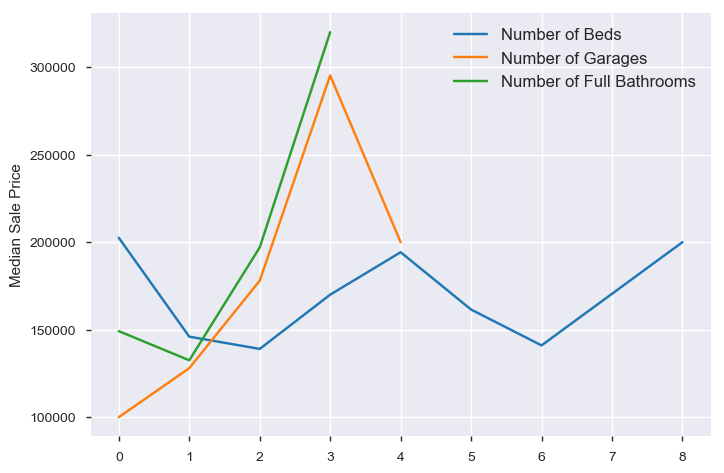

In [20]:
fig, ax = plt.subplots()
ax.plot(group_bed, label='Number of Beds')
ax.plot(group_garage, label='Number of Garages')
ax.plot(group_bath, label='Number of Full Bathrooms')
plt.ylabel('Median Sale Price')
legend = ax.legend(loc='upper right', shadow=True, fontsize='large')

Text(0,0.5,'Median Sale Price')

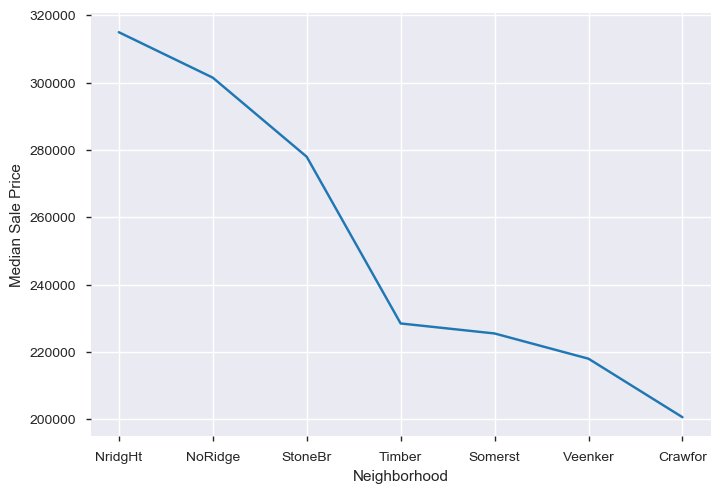

In [21]:
plt.plot(group_nbr.sort_values(ascending =False).head(7))
plt.xlabel('Neighborhood')
plt.ylabel('Median Sale Price')

## Modelling Begins

In [22]:
# Do the Linear Regression With MLR
lr = LinearRegression()
model = lr.fit(x_pre,y_pre)
score_own = model.score(x_pre,y_pre) 
score_test = model.score(x_post,y_post)
print('Own Score = ',score_own)
print('Test Score = ',score_test)

Own Score =  0.8753428706825549
Test Score =  0.8605655348777318


In [23]:
# Check the variance in the model
scores1 = cv_score(lr,x_pre, y_pre, cv=10)
print("Range of Scores:", max(scores1)-min(scores1))
print("Mean of Scores:",scores1.mean())
print("Variance of Scores:",scores1.std())

Range of Scores: 3.2261673623894325e+23
Mean of Scores: -3.391809643704325e+22
Variance of Scores: 9.626991477939398e+22


## This is a highly variant and overfitted model.

In [24]:
# Drop the columns by pvalues
model = sm.OLS(y_pre, x_pre).fit()
std = []

In [25]:
while len(model.pvalues[model.pvalues>0.01])>1:
    maxp = model.pvalues.idxmax()
    x_pre.drop(maxp,axis=1,inplace=True)
    model = sm.OLS(y_pre,x_pre).fit()
    scores = cv_score(lr,x_pre, y_pre, cv=5)
    std.append(scores.std())

Text(0,0.5,'Log (S.D of Score)')

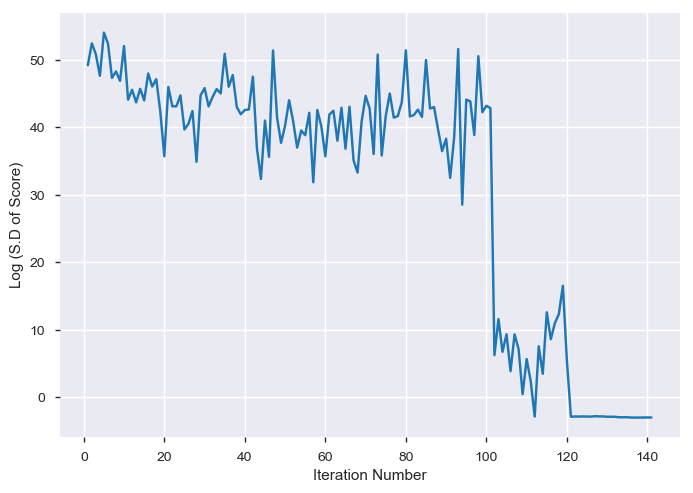

In [26]:
sns.lineplot(range(1,len(std)+1),np.log(std))
plt.xlabel('Iteration Number')
plt.ylabel('Log (S.D of Score)')

In [27]:
lr = LinearRegression()
model = lr.fit(x_pre,y_pre)
score_own = model.score(x_pre,y_pre) 
score_test = model.score(x_post[x_pre.columns],y_post)
print('Own Score = ',score_own)
print('Test Score = ',score_test)

Own Score =  0.8559094420669123
Test Score =  0.8541676807458075


In [28]:
# Check the variance in the model
scores2 = cv_score(lr,x_pre, y_pre, cv=10)
print("Cross Validation")
print("Range of Scores:", max(scores2)-min(scores2))
print("Mean of Scores:",scores2.mean())
print("Variance of Scores:",scores2.var())

Cross Validation
Range of Scores: 0.21042772025845624
Mean of Scores: 0.8038979400669127
Variance of Scores: 0.005073727880826786


Text(0,0.5,'Score')

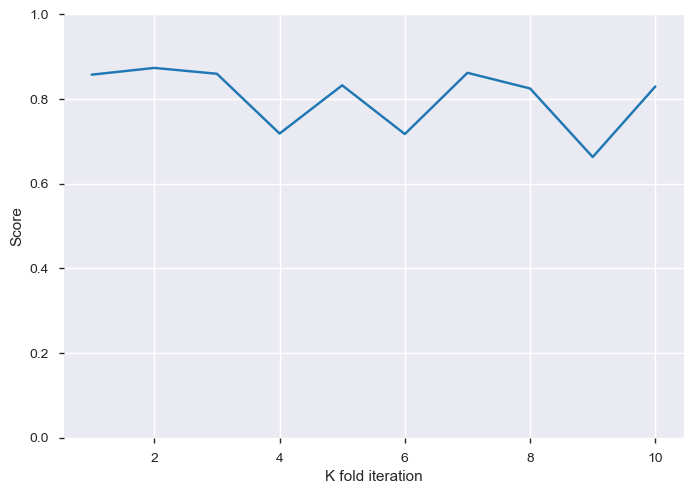

In [29]:
sns.lineplot(range(1,11),scores2)
plt.ylim ([0,1])
plt.xlabel ('K fold iteration')
plt.ylabel ('Score')

In [30]:
y_hat = model.predict(x_post[x_pre.columns])

Text(0,0.5,'Predicted Sale Price')

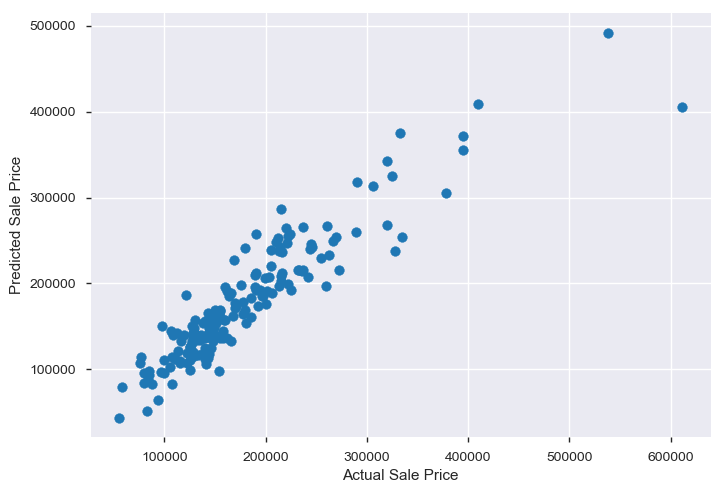

In [31]:
plt.scatter(y_post,y_hat)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

In [32]:
# Regularize using Lasso

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso.fit(x_pre, y_pre)
print(optimal_lasso.alpha_)


138.504048770829


In [33]:
# Construct Lasso using Optimized Lasso Alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cv_score(lasso, x_pre,y_pre, cv=10)
print(lasso_scores)
print('Mean of 10 fold Corss Validation Scores  = ',round(np.mean(lasso_scores),3))
print('S.D of 10 fold Corss Validation Scores   = ',round(np.std(lasso_scores),3))

[0.85967653 0.87073575 0.86365981 0.73846619 0.84052119 0.82762152
 0.87451364 0.82215387 0.64263254 0.83467919]
Mean of 10 fold Corss Validation Scores  =  0.817
S.D of 10 fold Corss Validation Scores   =  0.069


In [34]:
lasso.fit(x_pre,y_pre)
lasso_coefs = pd.DataFrame({'variable':x_pre.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [35]:
y_hat = lasso.predict(x_post[x_pre.columns])

In [36]:
lasso_coefs.head(10)

,variable,coef,abs_coef
15,Neighborhood_StoneBr,58109.807862,58109.807862
18,Condition2_PosN,-48272.968492,48272.968492
13,Neighborhood_NridgHt,47821.403586,47821.403586
12,Neighborhood_NoRidge,41204.640344,41204.640344
36,GarageCars_3,38302.377827,38302.377827
24,BedroomAbvGr_5,-35504.476601,35504.476601
21,FullBath_3,33052.405743,33052.405743
9,MSSubClass_160,-29233.650500,29233.650500
2,GrLivArea,28613.412982,28613.412982
26,KitchenAbvGr_2,-28424.022172,28424.022172


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

# A:

In [37]:
# Get the residuals on the pre 2010 data
lasso_residual = y - lasso.predict(dfr1[x_pre.columns])

Text(0,0.5,'Price in USD')

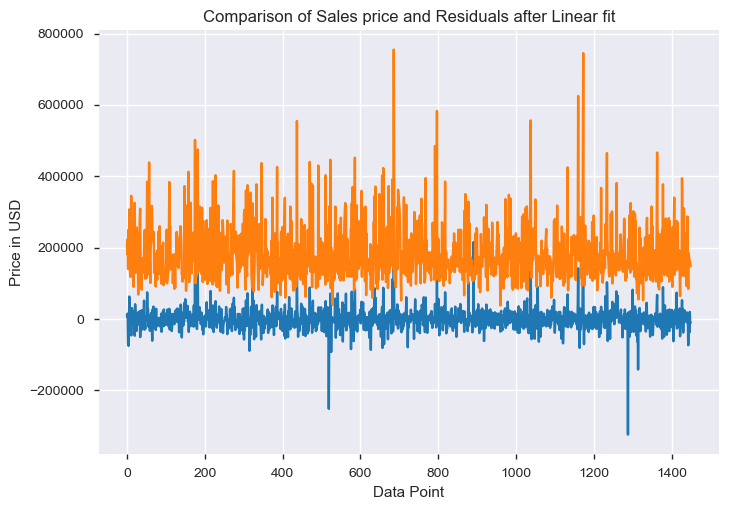

In [38]:
plt.plot(lasso_residual)
plt.plot(y_pre)
plt.title('Comparison of Sales price and Residuals after Linear fit')
plt.xlabel('Data Point')
plt.ylabel('Price in USD')

In [39]:
change = pd.Series(['Utilities','OverallQual','OverallCond','Exterior1st','Exterior2nd',\
                    'BsmtQual','ExterQual','ExterCond','BsmtCond','BsmtFinType1','BsmtFinSF1',\
                    'BsmtFinType2','BsmtFinSF2','BsmtUnfSF','HeatingQC','Electrical',\
                    'RoofStyle', 'RoofMatl','LowQualFinSF','KitchenQual','Functional',\
                    'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive'])

In [40]:
change_num = pd.Series(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','LowQualFinSF'])

In [41]:
change_cat = pd.Series (['Utilities','OverallQual','OverallCond','Exterior1st','Exterior2nd',\
                    'BsmtQual','ExterQual','ExterCond','BsmtCond','BsmtFinType1',\
                    'BsmtFinType2','HeatingQC','Electrical',\
                    'RoofStyle', 'RoofMatl','KitchenQual','Functional',\
                    'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive'])

In [42]:
# Standardize the Numerical variables and dummyfy the Categorical Variable for Variable Columns
x_var_num_std= ss.fit_transform(x[change_num])
x_var_num_std = pd.DataFrame(columns=x[change_num].columns,data=x_var_num_std)
dfr=x[change_cat]
dfr2=dfr.join(x_var_num_std)
dfr2=pd.get_dummies(dfr2,columns=change_cat,drop_first=True)
dfr2.shape


(1450, 127)

In [43]:
x_pre_ren = dfr2
y_pre_ren = lasso_residual[x_pre_ren.index]

In [44]:
# Do the MLR
model_r2 = lr.fit(x_pre_ren,y_pre_ren)
score_own_r2 = cv_score(lr,x_pre_ren,y_pre_ren,cv=10)
print('Mean of Linear Regresion is',np.mean(score_own_r2))
print('Standard Deviation of Linear Regresion is',np.std(score_own_r2))

Mean of Linear Regresion is -1.7108218404607873e+23
Standard Deviation of Linear Regresion is 2.5040778536115362e+23


# The model has very low accuracy and is highly variant. We will try to reduce the variance by p values and Lasso.

In [45]:
# Drop the columns by pvalues
model2 = sm.OLS(y_pre_ren, x_pre_ren).fit()
std2 = []

In [46]:
while len(model2.pvalues[model2.pvalues>0.01])>1:
    maxp = model2.pvalues.idxmax()
    x_pre_ren.drop(maxp,axis=1,inplace=True)
    model2 = sm.OLS(y_pre_ren,x_pre_ren).fit()
    scores2 = cv_score(lr,x_pre_ren, y_pre_ren, cv=5)
    std2.append(scores2.std())

Text(0,0.5,'Log (S.D of Score)')

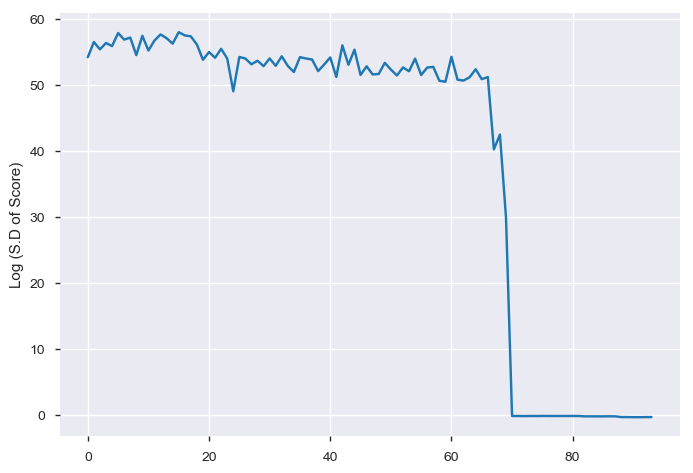

In [47]:
plt.plot(np.log(std2))
plt.ylabel('Log (S.D of Score)')


In [48]:
cv_score(lr,x_pre_ren, y_pre_ren, cv=5).std()

0.7536802126618791

In [49]:
# predict on 
model_r2 = lr.fit(x_pre_ren,y_pre_ren)
score_own = model_r2.score(x_pre_ren,y_pre_ren) 

print('Own Score = ',score_own)


Own Score =  0.30957262568534016


In [50]:
optimal_lasso_r2 = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso_r2.fit(x_pre_ren, y_pre_ren)
print(optimal_lasso_r2.alpha_)


64.87492649704367


In [51]:
# Construct Lasso using Optimized Lasso Alpha
lasso_r2= Lasso(alpha=optimal_lasso_r2.alpha_)
lasso_scores_r2 = cv_score(lasso_r2, x_pre_ren,y_pre_ren, cv=10)
print(lasso_scores_r2)
print(np.mean(lasso_scores_r2))
print(np.std(lasso_scores_r2))

[0.0612316  0.27615313 0.1810696  0.04923559 0.26756506 0.14792923
 0.24079071 0.17009812 0.05402153 0.15468317]
0.1602777744998225
0.08097124135797507


(0, 1)

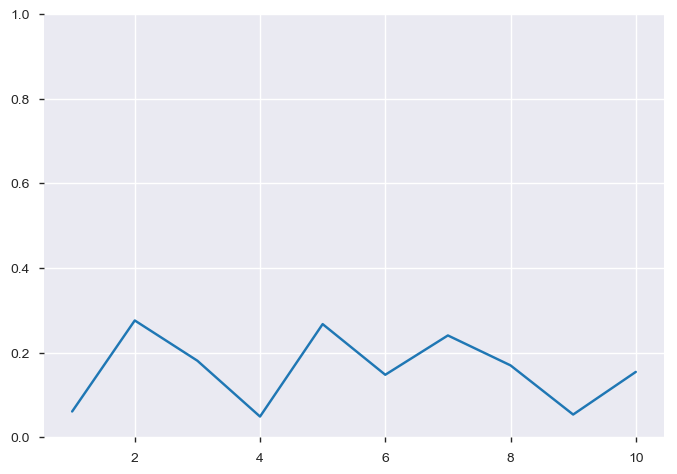

In [52]:
sns.lineplot(range(1,len(lasso_scores_r2)+1),lasso_scores_r2)
plt.ylim([0,1])

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.